# Multiple Boosting Algorithm Testing

In class and the previous assignment, we covered the process of boosted regression algorithms. In this assignment, we will look into more of a variety of regression methods to use as the $f$ and $h$ in a boosted algorithm. The specific methods we will use are Ordinary Least Squares (OLS), Neural Net (NN), and Random Forest (RF). I will use each permutation of these algorithms to determine which combination leads to the most effective boosted algorithm (based on mean squared error).

First, we will import some essential libraries for our analysis.

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.metrics import r2_score
from tensorflow.keras.optimizers import Adam

from scipy.linalg import lstsq
from scipy.sparse.linalg import lsmr
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, griddata, LinearNDInterpolator, NearestNDInterpolator
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, train_test_split as tts
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler
# next step: finish these imports

The follow function contains the core of our boosted algorithm. It takes two regression methods and data as input, and outputs predicted $y$ values on some test inputs.

In [29]:
def boosting(f, h, Xtrain, ytrain, Xtest):
  modelf = f(Xtrain, ytrain, Xtest)
  ypred_temp = modelf.predict(Xtrain)
  ypred_temp = ypred_temp.flatten()
  res = np.subtract(ytrain, ypred_temp)

  modelh = h(Xtrain, res, Xtest)
  ypred_res = modelh.predict(Xtrain)
  ypred_res = ypred_res.flatten()
  ypred = modelf.predict(Xtest).flatten() + modelh.predict(Xtest).flatten()
  #ypred = ypred_temp + ypred_res
  print("f: ", modelf.predict(Xtest).flatten())
  print("h: ", modelh.predict(Xtest).flatten())
  return ypred.flatten()

The following are the simple functions for training each of our three potential models.

In [11]:
def OLS(Xtrain, ytrain, Xtest):
  lin_reg = LinearRegression().fit(Xtrain, ytrain)
  #if returns == train:
    #ypred = lin_reg.predict(Xtrain)
  #else:
    #ypred = lin_reg.predict(Xtest)
  return lin_reg

In [12]:
def RF(Xtrain, ytrain, Xtest):
  model = RandomForestRegressor(n_estimators=100,max_depth=10)
  model.fit(Xtrain, ytrain)
  #if returns == train:
    #ypred = model.predict(Xtrain)
  #else:
    #ypred = model.predict(Xtest)
  return model

In [13]:
def NN(Xtrain, ytrain, Xtest):
  model = Sequential()
  model.add(Dense(64, activation="relu", input_dim=8))
  model.add(Dense(64, activation="relu"))
  model.add(Dense(64, activation="relu"))
  model.add(Dense(1, activation="linear"))
  model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=1e-2))

  model.fit(Xtrain,ytrain,validation_split=0.2, epochs=100, batch_size=100, verbose=0)
  #if returns == train:
    #ypred = model.predict(Xtrain)
  #else:
    #ypred = model.predict(Xtest)
  return model

The following function will use our boost algorithm, standardize the data, and return a mean squared error for the test data.

In [15]:
def get_mse(f, h, Xtrain, ytrain, Xtest, ytest):
  # Standardize all data; it will make comparison easier, and won't make any model worse.
  scale = StandardScaler()
  Xtrain = scale.fit_transform(Xtrain)
  Xtest = scale.transform(Xtest)
  ypred = boosting(f, h, Xtrain, ytrain, Xtest)
  #print("The mean squared error for a base",
        #str(f)[10:13],
        #"function boosted by a",
        #str(h)[10:13],
        #"function is",
        #mse(ytrain, ypred))
  return mse(ytest, ypred)

# Application of Boosted Algorithm

We will test our methods on a concrete strength data set. For each permutation of base function $f$ and booster function $h$, we will compute a 10-fold cross validated MSE. 

In [8]:
data = pd.read_csv('/concrete.csv')
y = data['strength'].values
X = data.drop(columns = 'strength').values

In [9]:
def kfold_mse(f, h, X, y):
  kf = KFold(n_splits=10,shuffle=True,random_state=4)
  mselist = []
  for idxtrain, idxtest in kf.split(X):
      Xtrain = X[idxtrain]
      ytrain = y[idxtrain]
      ytest = y[idxtest]
      Xtest = X[idxtest]
      mselist.append(get_mse(f, h, Xtrain, ytrain, Xtest, ytest))
  print("The mean squared error for a base",
        str(f)[10:13],
        "function boosted by a",
        str(h)[10:13],
        "function is",
        np.mean(mselist))
  return np.mean(mselist)

In [ ]:
kfolds = []
kfolds.append(kfold_mse(OLS, OLS, X, y))
kfolds.append(kfold_mse(OLS, NN, X, y))
kfolds.append(kfold_mse(OLS, RF, X, y))
kfolds.append(kfold_mse(NN, OLS, X, y))
kfolds.append(kfold_mse(NN, NN, X, y))
kfolds.append(kfold_mse(NN, RF, X, y))
kfolds.append(kfold_mse(RF, OLS, X, y))
kfolds.append(kfold_mse(RF, NN, X, y))
kfolds.append(kfold_mse(RF, RF, X, y))

In [31]:
kfolds = np.asarray(kfolds).reshape(3,3)

In [32]:
import matplotlib.pyplot as plt

# Results

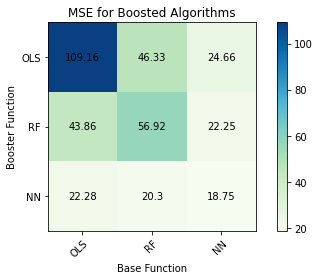

In [33]:
fig, ax = plt.subplots()
im = ax.imshow(kfolds, cmap='GnBu')
ax.set_title("MSE for Boosted Algorithms")
models = ['OLS', 'RF', 'NN']

ax.set_xticks(np.arange(len(models)))
ax.set_xticklabels(models)
ax.set_yticks(np.arange(len(models)))
ax.set_yticklabels(models)
ax.set_xlabel("Base Function")
ax.set_ylabel("Booster Function")

plt.colorbar(im)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(3):
    for j in range(3):
        text = ax.text(j, i, round(kfolds[i, j], 2),
                       ha="center", va="center", color="black")
fig.tight_layout()
plt.show()

As shown in the figure above, there is great variance in the MSE's of the various boosted regression algorithms tested. An OLS-OLS model was by far the least effective. This makes sense, as OLS does not benefit from the booster; the model of residuals is negligible due to the nature of the regression method. Of the remaining algorithms, the biggest factor in efficacy seems to be the presence of a neural network, especially as a booster. This algorithm's ability to deal with erratic relationships, such as those in residual data, may contribute to this. The most effective algorithm, albeit marginally, was the NN-NN algorithm. This surprised me; I expected to see a combination of algorithms to compliment themselves stronger than any which was used for both $f$ and $h$. The simplest conclusion is that NN are very effective with the data we are working with.

# LightGBM

LightGBM, like XGBoost which was covered in the previous assignment, is an algorithm which uses RF as a base function and boosted function. However, it uses some novel methods to selectively reduce runtime without sacrificing accuracy. The first of which, *Gradient Based One-Side Sampling*, trains the $h$ model solely on higher magnitude residuals. This permits fewer operations in designing the residual model, while not losing much information from negligible data points.

The second method is *Exclusive Feature Bundling*. This takes features which rarely have non-zero values for the same observation and combines them to reduce the number of trivial operations necessary for calculation. In the case of our data, the *superplastic* and *ash* variables are sparse enough that the algorithm likely combined them.

We will apply this algorithm to our concrete strength data to compare it to the algorithms we have already developed.

In [ ]:
!pip install lightgbm

In [ ]:
import lightgbm as lgb

In [ ]:
def get_mse_lgb(Xtest, ytest, Xtrain, ytrain):
  trainLGB = lgb.Dataset(Xtrain, ytrain)
  testLGB = lgb.Dataset(Xtest, ytest)

  param = {'num_leaves': 10, 'objective': 'mse'}
  param['metric'] = 'mse'

  model = lgb.train(param, trainLGB)
  ypred = model.predict(Xtest, num_iteration=model.best_iteration)
  return mse(ytest, ypred)

In [ ]:
def kfold_mse_lgb(X, y):
  kf = KFold(n_splits=10,shuffle=True,random_state=4)
  mselist = []
  for idxtrain, idxtest in kf.split(X):
      Xtrain = X[idxtrain]
      ytrain = y[idxtrain]
      ytest = y[idxtest]
      Xtest = X[idxtest]
      mselist.append(get_mse_lgb(Xtrain, ytrain, Xtest, ytest))
  print("The mean squared error for the LGB function is",
        np.mean(mselist))
  return np.mean(mselist)

In [ ]:
kfold_mse_lgb(X, y)

The mean squared error for the LGB function is 64.15496940027298


64.15496940027298

64.15 is not as good as most of our algorithms. In fact, it is not even as good as the RF-RF model, which is the closest comparison of those tested. However, the advantages of the algorithm are not in its accuracy, but rather its speed. For a dataset larger than ours, it is likely the advantages of LightGBM would outweigh its drawbacks.